In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tables
import pandas as pd
import numpy as np
from toolz import memoize
from toise import plotting, surfaces, util, effective_areas, angular_resolution
import matplotlib as mpl
import photospline
from scipy import optimize
'''from autograd.misc.flatten import flatten_func
import autograd
import autograd.numpy as n'''
import os
import histlite 
import nuflux
import tables
import histlite as hl
#import warnings
#warnings.filterwarnings("ignore") # turn off warnings

In [2]:
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = mpl.rcParams['savefig.facecolor'] = 'w'
mpl.rcParams['legend.framealpha'] = 1
mpl.rc('font', size=12)

In [3]:
base_dir = '/home/steve/pone/data/'

In [4]:
f = tables.open_file(base_dir + 'Nugen_70_daq.hdf5')

In [5]:
len(f.root.I3EventHeader.cols.Event[:])

16440

In [6]:
#len(f.root.I3EventHeader.cols.Event[:]) / 352.

In [7]:
'''fig, axs = plt.subplots(2,2, figsize=(9,9))
f = tables.open_file(base_dir + '3_no_reco.hdf5')
ax = axs[0][0]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with NO RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '70_no_reco.hdf5')
ax = axs[0][1]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with NO RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '3_reco.hdf5')
ax = axs[1][0]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('3 String with RECO')
ax.set_xlabel('Event Number in File')

f = tables.open_file(base_dir + '70_reco.hdf5')
ax = axs[1][1]
ax.hist(f.root.I3EventHeader.cols.Event[:]);
ax.set_title('70 String with RECO')
ax.set_xlabel('Event Number in File')

plt.tight_layout()'''

"fig, axs = plt.subplots(2,2, figsize=(9,9))\nf = tables.open_file(base_dir + '3_no_reco.hdf5')\nax = axs[0][0]\nax.hist(f.root.I3EventHeader.cols.Event[:]);\nax.set_title('3 String with NO RECO')\nax.set_xlabel('Event Number in File')\n\nf = tables.open_file(base_dir + '70_no_reco.hdf5')\nax = axs[0][1]\nax.hist(f.root.I3EventHeader.cols.Event[:]);\nax.set_title('3 String with NO RECO')\nax.set_xlabel('Event Number in File')\n\nf = tables.open_file(base_dir + '3_reco.hdf5')\nax = axs[1][0]\nax.hist(f.root.I3EventHeader.cols.Event[:]);\nax.set_title('3 String with RECO')\nax.set_xlabel('Event Number in File')\n\nf = tables.open_file(base_dir + '70_reco.hdf5')\nax = axs[1][1]\nax.hist(f.root.I3EventHeader.cols.Event[:]);\nax.set_title('70 String with RECO')\nax.set_xlabel('Event Number in File')\n\nplt.tight_layout()"

In [8]:
#f.root.I3MCWeightDict.cols.OneWeight

In [9]:
def make_array_nugen(string, reco=False, nfiles=1000, nevents=100):

    f = tables.open_file(base_dir + 'Nugen_{}_daq.hdf5'.format(string))
    event = f.root.I3EventHeader.cols.Event[:]
    true_zenith = f.root.NuGPrimary.cols.zenith[:]
    true_azimuth = f.root.NuGPrimary.cols.azimuth[:]
    true_energy = f.root.NuGPrimary.cols.energy[:]
    oneweight = f.root.I3MCWeightDict.cols.OneWeight[:]
    ow = oneweight / (nfiles * nevents)
  
    w_astro = 1e-18 *ow *(true_energy/1e5)**-2
    w_atmo = 1e-18 *ow *(true_energy/1e5)**-3.7
    flux = nuflux.makeFlux('H3a_SIBYLL23C')
    nu_type=nuflux.NuMu
    nu_energy=true_energy # in GeV
    nu_cos_zenith = np.cos(true_zenith)
    w_h3a =2*ow* flux.getFlux(nu_type,nu_energy,nu_cos_zenith)

  
    array = np.vstack([event, true_zenith, true_azimuth, true_energy, ow, w_astro, w_atmo, w_h3a])
    df = pd.DataFrame(array.T, 
                      columns=['event' , 'true_zenith', 'true_azimuth', 'true_energy',  'ow', 
                               'w_astro','w_atmo', 'w_h3a'])
    return df

In [10]:
mc = {}
strings = [10, 70]
nfiles = [1000,1000]
nevents = [100, 100]
for i, string in enumerate(strings):
    mc[string] = make_array_nugen(string, reco=False, nfiles=nfiles[i], nevents=nevents[i])

In [11]:
#rates
for string in [10, 70]:
    print('----------')
    print('{} String : {:.2} Hz, Astro Events / year: {:.3}'.format(string, sum(mc[string].w_astro), 
                                                                     sum(mc[string].w_astro) * 1 * 365 * 86400))
    print('{} String : {:.2} Hz, Atmo Events (E^-3.7)/ year: {:.3}'.format(string, sum(mc[string].w_atmo), sum(mc[string].w_atmo) * 1 * 365 * 86400))
    print('{} String : {:.2} Hz, Atmo Events H3a / year: {:.3}'.format(string, sum(mc[string].w_h3a), 
                                                                        sum(mc[string].w_h3a) * 1 * 365 * 86400))

    print(' ')

----------
10 String : 1.8e-07 Hz, Astro Events / year: 5.69
10 String : 0.00012 Hz, Atmo Events (E^-3.7)/ year: 3.84e+03
10 String : 0.00013 Hz, Atmo Events H3a / year: 4.23e+03
 
----------
70 String : 1.6e-06 Hz, Astro Events / year: 51.1
70 String : 0.00085 Hz, Atmo Events (E^-3.7)/ year: 2.67e+04
70 String : 0.0011 Hz, Atmo Events H3a / year: 3.33e+04
 


In [12]:
'''strings = [3,10,70]
nfiles = [997, 328, 352]
nevents = [100, 100, 32]
MC = {}
for i, string in enumerate(strings):
    dats = pd.read_csv("/home/steve/pone/scripts///data_toise_sensitivity_strippedreco_16pmts_{}string_geometry.csv".format(int(string)))
    dats['ow'] = dats['effective_area'] / (nfiles[i] * nevents[i])
    dats['true_zenith'] = dats['zenith_angle']
    dats['true_energy'] = dats['muon_energy']
    MC[string] = dats'''

'strings = [3,10,70]\nnfiles = [997, 328, 352]\nnevents = [100, 100, 32]\nMC = {}\nfor i, string in enumerate(strings):\n    dats = pd.read_csv("/home/steve/pone/scripts///data_toise_sensitivity_strippedreco_16pmts_{}string_geometry.csv".format(int(string)))\n    dats[\'ow\'] = dats[\'effective_area\'] / (nfiles[i] * nevents[i])\n    dats[\'true_zenith\'] = dats[\'zenith_angle\']\n    dats[\'true_energy\'] = dats[\'muon_energy\']\n    MC[string] = dats'

In [13]:
mc[70]

,event,true_zenith,true_azimuth,true_energy,ow,w_astro,w_atmo,w_h3a
0,11.0,0.415700,1.278811,9.724313e+06,3.440733e+10,3.638589e-12,1.519053e-15,3.971925e-15
1,22.0,1.201836,0.900556,1.032303e+06,7.304058e+09,6.854094e-11,1.295621e-12,3.541336e-12
2,25.0,1.743233,1.926361,1.539020e+05,1.549120e+09,6.540284e-10,3.142543e-10,2.465020e-09
3,34.0,0.327752,4.927663,6.555674e+05,4.840500e+08,1.126304e-11,4.606871e-13,7.889010e-13
4,40.0,0.055238,4.197920,3.058710e+05,1.504935e+07,1.608575e-12,2.404508e-13,4.488323e-13
...,...,...,...,...,...,...,...,...
16435,80.0,0.532145,5.705308,9.264227e+03,6.879710e+05,8.015891e-11,4.574844e-09,9.768758e-09
16436,88.0,0.238347,1.906299,5.710755e+04,8.183784e+06,2.509384e-11,6.504113e-11,1.365551e-10
16437,90.0,1.325054,4.095219,6.897265e+06,1.745167e+11,3.668454e-11,2.746201e-14,8.315763e-14
16438,92.0,0.385744,2.602681,6.125780e+05,5.397898e+08,1.438473e-11,6.602789e-13,1.141265e-12


In [15]:
import astropy as astro

In [19]:
bear_mountain = EarthLocation(lat=41.3*u.deg, lon=-74*u.deg, height=390*u.m)

In [42]:
#aeffs is area_weight in units of GeV m^2 sr similar to oneweight 
# but oneweight is in terms of cm^2

In [43]:
def effa_plot_notlogged(ax, mc_dict, string=70, zen_deg_min = 0, zen_deg_max = 180, 
                        selection_eff = 1,label = 'MISC', color = 'k', ls = '-'):
    a = mc_dict[string]
    mask = (a.true_zenith < np.radians(zen_deg_max)) & (a.true_zenith > np.radians(zen_deg_min))
    
    dlogE=.1
    bins = 10**np.arange(2,7.01,dlogE)
    solid_angle=4*np.pi #2*np.pi*(np.cos(np.radians(zen_deg_min))) - np.cos(np.radians(zen_deg_max))
    area=  (1/(1e4*np.log(10)) * (a.ow[mask] / ( (a.true_energy[mask]) *  solid_angle *  dlogE)))
    #(1/1e4*np.log(10)) *
    h = hl.hist((a.true_energy[mask]), 
                #weights=dats.effective_area[mask] / (solid_angle * dlogE), 
                weights = selection_eff *area,
                bins=bins);
    hl.plot1d(h, histtype='step', linewidth=2, color=color, label=label, ls = ls, log=True)
    ax.loglog()

    ax.grid()
    #ax.legend(loc='lower right')
    ax.set_ylabel('$A_\mathsf{Eff}$($m^2$)')
    ax.set_xlabel('log$_{10}$(E) [1/GeV]')

    #ax.set_xlim((10**2,10**7))
    #ax.set_ylim((1e-4,1e3))
    plt.tight_layout()
    return h

In [44]:
pstracks_hist = np.load('/home/steve/pone/data/pstracks_effa_all.hist.npy', allow_pickle=True)[()]
#dnnc_hist = np.load('/home/steve/pone/data/DNNC_effa_all.hist.npy', allow_pickle=True)[()]
#pstracks_hist = np.load('/home/steve/pone/data/pstracks_effa_north.hist.npy', allow_pickle=True)[()]

In [45]:
selection_eff = .004/32

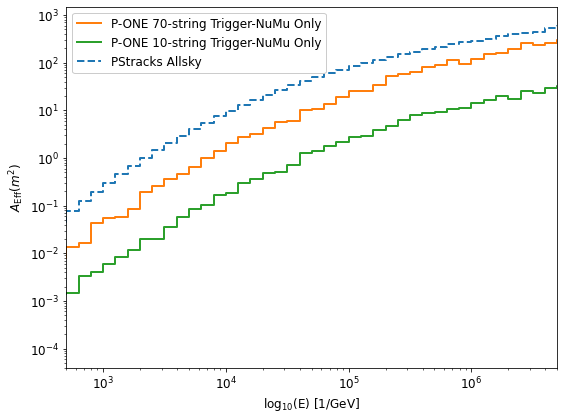

In [46]:
colors = ['C3', 'C1']
strings = [70]
fig,ax = plt.subplots(figsize=(8,6))

effa_plot_notlogged(ax, mc,  string= 70,label='P-ONE 70-string Trigger-NuMu Only', color='C1', ls='-')
effa_plot_notlogged(ax, mc,   string = 10, label='P-ONE 10-string Trigger-NuMu Only', color='C2', ls='-')
#effa_plot_notlogged(ax, mc,   string = 3, label='P-ONE 3-string Trigger', color='C3', ls='-')

#effa_plot_notlogged(ax, mc,selection_eff=selection_eff,  string= 70,label='P-ONE 70-string pstracksEff', color='C1', ls=':')
#effa_plot_notlogged(ax, mc, selection_eff=selection_eff,  string = 10, label='P-ONE 10-string pstracksEff', color='C2', ls=":")
#effa_plot_notlogged(ax, mc,  selection_eff=selection_eff, string = 3, label='P-ONE 3-string pstracksEff', color='C3', ls=':')

hl.plot1d(pstracks_hist, label='PStracks Allsky', c='C5', ls='--')
#hl.plot1d(dnnc_hist, label='DNNCascade Allsky', c='C6', ls='--')

plt.xlim(500,5e6)
#plt.ylim(1e2,1e4)
plt.legend(ncol=1)

In [47]:
#Effective Area / Geometric Area IceCube & Pone

In [48]:
pstracks_mc = np.load('/home/steve/pone/version-004-p00/IC86_2016_MC.npy')

In [49]:
pstracks_mc

array([(21002,  88, 0, 0.77238118,  1.49871973, 1.91721649, 3.05900294, 0., 2.93977788, 0.03371643, 0.66034693,  1.48476787, 1.99974742, 3.04425004, 3.78357444e+02, 1.86864017e-02),
       (21002,  99, 0, 3.39477065,  0.50997965, 5.46216398, 2.09416208, 0., 2.82153526, 0.01988616, 3.42595766,  0.49369645, 5.43082132, 2.07777119, 3.08365386e+02, 2.11067879e-01),
       (21002, 257, 0, 1.41479533,  0.24044122, 1.16397796, 1.80891875, 0., 4.69598949, 0.002125  , 1.41597142,  0.24139219, 1.16281639, 1.80988556, 5.12407276e+05, 7.58640619e+08),
       ...,
       (21220, 110, 0, 4.2441402 , -0.44680837, 4.62050882, 1.13042019, 0., 5.40085406, 0.00305321, 4.23752586, -0.44540054, 4.6270813 , 1.13190876, 2.52991244e+06, 2.49895877e+09),
       (21220, 117, 0, 5.07878305, -1.00375654, 3.80057774, 0.56233271, 0., 5.44797306, 0.00384572, 5.06564556, -1.00320623, 3.81378298, 0.56305531, 2.17925202e+05, 8.38040811e+06),
       (21220, 118, 0, 5.25095648, -0.19664719, 3.61024664, 1.36723344, 0., 5.

In [50]:
#pstracks 2d effa
d_logE = .2
d_zen = 2 * np.pi * np.diff(np.linspace(-1,1,50))[0] 
a = pstracks_mc
bins = (np.arange(2,7.01,d_logE), np.linspace(-1,1,50))

area = (1/(1e4*np.log(10)) * (a['ow'] / (a['trueE'] * d_zen * d_logE)))
#range = [(-1,1), (3,6)]
h2d = hl.hist((np.log10(a['trueE']), np.cos(a['trueZen'])),
              weights=area,
              bins=bins)


Text(0.5, 0, 'log$_{10}$(E) [1/GeV]')

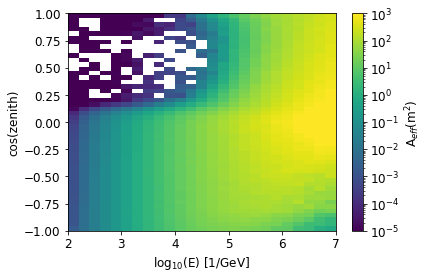

In [51]:
fig, ax = plt.subplots()
hl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)', log=True, vmin=1e-5, vmax=1e3)
ax.set_yticks(np.arange(-1,1.01,.25))
ax.set_ylabel('cos(zenith)')
ax.set_xlabel('log$_{10}$(E) [1/GeV]')

In [52]:
np.save('/home/steve/pone/data/pstracks_nu_effa', h2d)


In [53]:
np.diff(np.linspace(-1,1,50))[0]

0.04081632653061229

In [54]:
def effa2d(string):
    d_logE = .2
    d_zen = 2 * np.pi * np.diff(np.linspace(-1,1,50))[0] 
    a = mc[string]
    bins = (np.arange(2,7.01,d_logE), np.linspace(-1,1,50))

    area = (1/(1e4*np.log(10)) * (a.ow / (a.true_energy * d_zen * d_logE)))
    #range = [(-1,1), (3,6)]
    h2d = hl.hist((np.log10(a.true_energy), np.cos(a.true_zenith)),
                  weights=area,
                  bins=bins)
    return h2d

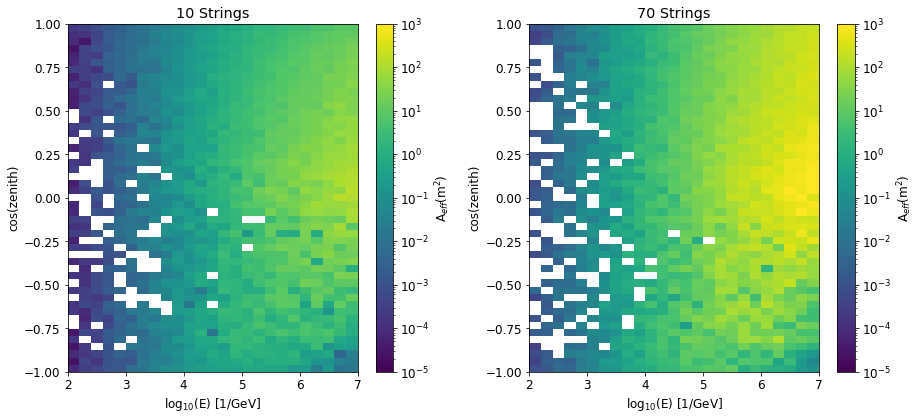

In [55]:
save =True
plt.rc('font', size=12)
fig, axs = plt.subplots(1,2, figsize=(13,6))
#vmins = [1e2, 5e2, 1e3]
#vmaxs=[1e3,5e3,1e4]
for i, string in enumerate([10, 70]):
    ax = axs[i]
    h2d = effa2d(string)
    if save:
        np.save('/home/steve/pone/data/PONE_nu_effa_{}_string'.format(string), h2d)
    #fig, ax = plt.subplots()
    hl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)', log=True, vmin=1e-5, vmax=1e3)
    ax.set_yticks(np.arange(-1,1.01,.25))
    ax.set_ylabel('cos(zenith)')
    ax.set_xlabel('log$_{10}$(E) [1/GeV]')
    ax.set_title('{} Strings'.format(string))
    #ax.set_aspect('equal')
plt.tight_layout()

In [56]:
h2d

Hist(25 bins in [2.0,7.000000000000004], 49 bins in [-1.0,1.0], with sum 73844.22012624066, 113 empty bins, and 0 non-finite values)